<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Laboratorio 3 - Contexto</h2>
    <h2> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> 2025-1</h2>
</center>

Correr el siguiente bloque solo 1 vez

In [2]:
!pip install pillow
!pip install scipy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy.ndimage import convolve1d
from scipy.linalg import toeplitz

# Laboratorio 3: Modelado de desenfoque en imágenes mediante operadores lineales

En este laboratorio exploraremos el proceso de desenfoque de una imagen utilizando operadores lineales en forma de **matrices de convolución**, específicamente matrices Toeplitz construidas a partir de un núcleo Gaussiano.

El desenfoque de una imagen es una operación fundamental en procesamiento de imágenes y se puede modelar matemáticamente como una multiplicación matricial. En lugar de aplicar una función de convolución tradicional sobre una imagen, representaremos el desenfoque mediante una **operación lineal separable**, en la que una imagen bidimensional es multiplicada por matrices que difuminan por **filas** y por **columnas**.

Adicionalmente, se agregará **ruido** a la imagen desenfocada, con el objetivo de obtener una versión degradada de la imagen original.

El enfoque principal de este laboratorio, y el desafío que se plantea, consiste en que ustedes logren **restaurar la imagen degradada** aplicando conceptos de álgebra lineal. Para ello, deberán utilizar **operaciones matriciales** junto con las propiedades de la **descomposición en valores singulares (SVD)**, con el fin de reconstruir una versión lo más **cercana** posible de la imagen original.

El procedimiento de desenfoque se modela con las matrices $A_c$ y $A_r$, las cuales operan sobre las columnas y filas de la imagen $X_{true}$, respectivamente. 
Es decir:
$$
\underbrace{A_c\,X_{\text{true}}\,A_r^\top}_{\displaystyle{B_{\text{true}}}} + \Xi = B_{\text{data}},
$$
donde:
- $X_{\text{true}}$: imagen original (en escala de grises).
- $A_c$ : matriz que aplica el desenfoque por columnas.
- $A_r$: matriz que aplica el desenfoque por filas.
- $\Xi$: ruido Gaussiano aditivo asociado al proceso de captura de la imagen.
- $B_{\text{true}}$: imagen desenfocada resultante sin considerar el ruido $\Xi$.
- $B_{\text{data}}$: imagen degradada que se quiere corregir. Esta es la data que se tiene a disposición.

Ambas matrices  $A_c$ y $A_r $ son construidas a partir de un filtro gaussiano discreto, y suelen ser matrices Toeplitz simétricas, y por simplicidad se usará $A_c=A_r$.

Este enfoque no solo permite aplicar desenfoques, sino también estudiar su inversión, lo que se utilizará más adelante para **restauración de imágenes** .

---

Funcion que retorna las 2 matrices de convolución $A_c$ y $A_r$:

In [4]:
# Construcción de operadores de 'desenfoque'
def blur_operator(m, n, bl=1):
    """
    Descripción: Genera los operadores de convolución 1-D empleados
    ---------- 
    inputs:
    ----------
    m, n : int
        Dimensiones de la imagen (filas = m, columnas = n).
    bl : {1, 2}
        1  → blur simétrico  (σ_r = σ_c = 0.01)
        2  → blur asimétrico (σ_r = 0.02, σ_c = 0.01)
    ----------
    outputs:
    ----------
    Ac : ndarray (m, m)
        Matriz Toeplitz que difumina horizontalmente (columnas).
    Ar : ndarray (n, n)
        Matriz Toeplitz que difumina verticalmente (filas).
    """
    # --- 1. Parámetros ----------------------------------------------------
    sigmac = 0.01
    sigmar = 0.02 if bl == 2 else sigmac
    # --- 2. Nucleos 1-D ---------------------------------------------------
    c_pos = np.linspace(0, 1, m) # coordenadas normalizadas
    r_pos = np.linspace(0, 1, n)

    c = np.exp(-0.5 * (c_pos / sigmac) ** 2)
    r = np.exp(-0.5 * (r_pos / sigmar) ** 2)
    # umbral 1e-4 
    c[c < 1e-4] = 0.0
    r[r < 1e-4] = 0.0

    # Normalización: división por (2·sum − valor central)
    c /= (2 * c.sum() - c[0])
    r /= (2 * r.sum() - r[0])
    # --- 3. Matrices Toeplitz --------------------------------------------
    Ac = toeplitz(c)          # (m × m)
    Ar = toeplitz(r)          # (n × n)
    return Ac, Ar


Cargamos la imagen y la desenfocamos

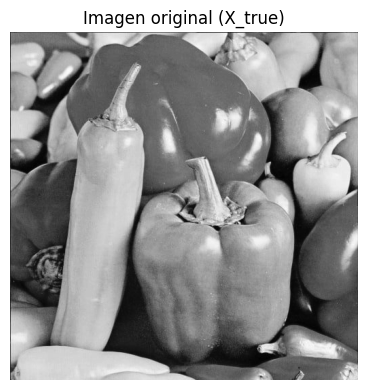

In [5]:
# Paso 1: Cargar imagen original y convertir a escala de grises
img = Image.open("img.jpg").convert("L")
img = img.resize((512, 512))
X_true = np.array(img) / 255.0  # Imagen original normalizada

# Mostrar imagen original
plt.figure(figsize=(5,4))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Imagen original (X_true)')
plt.tight_layout()
plt.show()

B_blur shape: (512, 512)


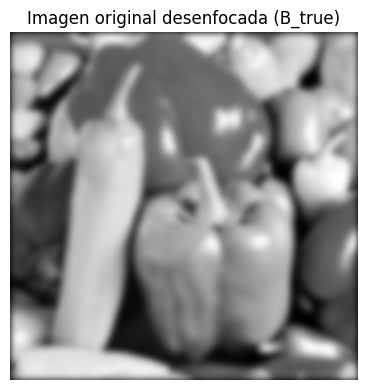

In [6]:
# Paso 2: Definir el operador de desenfoque
Ac, Ar = blur_operator(512, 512, bl=1)

# Paso 3: Aplicar el operador de desenfoque
B_blur = Ac @ X_true @ Ar.T
print("B_blur shape:", B_blur.shape)

# Mostrar imagen desenfocada
plt.figure(figsize=(5,4))
plt.imshow(B_blur, cmap='gray')
plt.axis('off')
plt.title('Imagen original desenfocada (B_true)')
plt.tight_layout()
plt.show()

B_data shape: (512, 512)


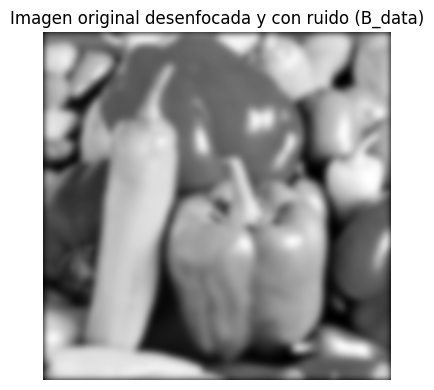

In [7]:
# Paso 4: Cargar ruido definido previamente
ruido=np.load('ruido.npy')  # Ruido gaussiano dado

# Paso 5: Agregar ruido a la imagen desenfocada
B_data = B_blur + ruido
print("B_data shape:", B_data.shape)


# Mostrar imagen desenfocada más ruido Gaussiano
plt.figure(figsize=(5,4))
plt.imshow(B_blur, cmap='gray')
plt.axis('off')
plt.title('Imagen original desenfocada y con ruido (B_data)')
plt.tight_layout()
plt.show()

### Pasos para la reconstrucción

Para la realización de la reconstrucción de una **aproximación** la imagen $X_{\text{true}}$ desde la imagen $B$ se puede realizar _despejando_ $X_{\text{true}}$, es decir,
$$
\begin{align*}
    A_c\,X_{\text{true}}\,A_r^\top+\Xi &=B_{\text{data}},\tag{1.1}\\
    A_c\,X_{\text{true}}\,A_r^\top &=B_{\text{data}}-\Xi,\\
    X_{\text{true}}\,A_r^\top &=A_c^{-1}\left(B_{\text{data}}-\Xi\right),\\
    X_{\text{true}} &=A_c^{-1}\,\left(B_{\text{data}}-\Xi\right)\,A_r^{-\top},\\
    X_{\text{true}} &=\left(A_c^{-1}\,B_{\text{data}}-A_c^{-1}\,\Xi\right)\,A_r^{-\top},\\
    X_{\text{true}} &=A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}-A_c^{-1}\,\Xi\,A_r^{-\top}.\tag{1.2}
\end{align*}$$
Esto nos indica que si computamos $A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}$ directamente no obtendremos $X_{\text{true}}$ dado que desconocemos el término $\Xi$.
Incluso podemos determinar que la diferencia entre $X_{\text{true}}$ y $A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}$ es exactamente $-A_c^{-1}\,\Xi\,A_r^{-\top}$, y si calculamos una norma matricial de la diferencia se obtiene,
$$
    \left\|X_{\text{true}}-A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}\right\| = \left\|A_c^{-1}\,\Xi\,A_r^{-\top}\right\|.
$$
Entonces, para poder lograr reducir esta diferencia entre la imagen original $X_{\text{true}}$ y la imagen reconstruida se propone el siguiente procedimiento:
1. Descomponer el operador $A_c^{-1}$, es decir $A_c^{-1}=A_{c,\text{trunc}}^{-1}+A_{c,\text{res}}^{-1}$
2. Descomponer el operador $A_r^{-\top}$, es decir $A_r^{-\top}=A_{r,\text{trunc}}^{-\top}+A_{r,\text{res}}^{-\top}$

donde `trunc` denota el truncamiento del operador y `res` denota el residuo resultante del truncamiento.
El siguiente paso corresponde a reemplazar la descomposición de los operadores en el término $A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}$ de la ecuación (1.2), es decir,
$$
\begin{align*}
    A_c^{-1}\,B_{\text{data}}\,A_r^{-\top} &= \left(A_{c,\text{trunc}}^{-1}+A_{c,\text{res}}^{-1}\right)
                                                B_{\text{data}}
                                                \left(A_{r,\text{trunc}}^{-\top}+A_{r,\text{res}}^{-\top}\right)\\
                                            &= A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}+\Lambda_{\text{res}}, \tag{1.3}
\end{align*}
$$
donde 
$\Lambda_{\text{res}}=
A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{res}}^{-\top}
+A_{c,\text{res}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}
+A_{c,\text{res}}^{-1}\,B_{\text{data}}\,A_{r,\text{res}}^{-\top}$.
Notar que si no existe truncamiento, entonces la matriz $\Lambda_{\text{res}}$ sería la matriz nula.
Entonces, reemplazando la descomposición (1.3) en la ecuación (1.2) se obtiene,
$$
\begin{align*}
    X_{\text{true}} &= A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}-A_c^{-1}\,\Xi\,A_r^{-\top}\\
                    &= \underbrace{A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}}_{\displaystyle{X_{\text{recon}}}}+\Lambda_{\text{res}}-A_c^{-1}\,\Xi\,A_r^{-\top}.
\end{align*}
$$
Ahora, denotando $X_{\text{recon}}=A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}$ como la imagen reconstruida, podemos obtener nuevamente la norma de la diferencia entre la imagen original y la imagen reconstruida de la siguiente forma,
$$
\begin{align*}
    \left\|X_{\text{true}}-X_{\text{recon}}\right\|=\left\|\Lambda_{\text{res}}-A_c^{-1}\,\Xi\,A_r^{-\top}\right\|.
\end{align*}
$$
Por lo tanto, si el truncamiento es exitoso se puede lograr que el error de la reconstrucción por medio de truncamiento sea menor que utilizar los operadores originales, es decir, estudiaremos las condiciones para que esto se logre lo siguiente,
$$
\left\|\Lambda_{\text{res}}-A_c^{-1}\,\Xi\,A_r^{-\top}\right\|=\left\|X_{\text{true}}-X_{\text{recon}}\right\|\leq\left\|X_{\text{true}}-A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}\right\|= \left\|A_c^{-1}\,\Xi\,A_r^{-\top}\right\|.
$$
El éxito del procedimiento implica que se obtiene una imagen más cercana a la original por medio del truncamiento que utilizar los operadores sin truncar.
_Este procedimiento de aproximación es lo que se estudiará en el laboratorio_.

**Su objetivo será implementar esta expresión paso a paso utilizando operaciones matriciales y aplicar la descomposición SVD para obtener la mejor estimación posible de la imagen original para la problemática particular que se le entregue.**

### Funciones que seran utilizadas


Funcion `np.linalg.svd(A, full_matrices=False)` --> obtiene la descomposicion en valores singulares (svd) de la matriz A.

In [8]:
A = np.array([[1., 2., 3.],
              [4., 5., 6.],
              [7., 8., 9.]])

Uc, Sc, VcT = np.linalg.svd(A, full_matrices=False)
print('Uc:',Uc)
print('Sc:',Sc)
print('VcT:',VcT)


Uc: [[-0.21483724  0.88723069  0.40824829]
 [-0.52058739  0.24964395 -0.81649658]
 [-0.82633754 -0.38794278  0.40824829]]
Sc: [1.68481034e+01 1.06836951e+00 4.41842475e-16]
VcT: [[-0.47967118 -0.57236779 -0.66506441]
 [-0.77669099 -0.07568647  0.62531805]
 [-0.40824829  0.81649658 -0.40824829]]


Funcion `np.argsort()` --> obtiene los i`dices originales ordenados de los mayores o menores elementos.

In [9]:
a = np.array([30, 10, 50, 20])

# Obtener los índices que ordenarían el array
indices_ordenados = np.argsort(a)

print("Índices ordenados menor a mayor:", indices_ordenados)  # [1 3 0 2]
print("Array ordenado:", a[indices_ordenados])  # [10 20 30 50]

indices_ordenados = np.argsort(a)[::-1]
print("Índices ordenados de mayor a menor:", indices_ordenados)  # [2 0 3 1]
print("Array ordenado:", a[indices_ordenados])  # [10 20 30 50]

n_indices_ordenados= np.argsort(a)[::-1][:2] #n=2
print("Los primeros n indices ordenados de mayor a menor:", n_indices_ordenados)  # [2 0]
print("Array ordenado:", a[n_indices_ordenados])  # [50 30]


Índices ordenados menor a mayor: [1 3 0 2]
Array ordenado: [10 20 30 50]
Índices ordenados de mayor a menor: [2 0 3 1]
Array ordenado: [50 30 20 10]
Los primeros n indices ordenados de mayor a menor: [2 0]
Array ordenado: [50 30]


Funcion `.ravel()` --> aplana un arreglo multidimensional, conviritendolo en un arreglo plano 1D, cada fila se concatena con la que sigue.

In [10]:
A = np.array([[1., 2., 3.],
              [4., 5., 6.],
              [7., 8., 9.]])

r = A.ravel()
print(r)

# funciona solo como vista, es decir, no se copia el array y A no se modifica, sigue siendo una matriz
print(A)

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


Funcion `np.zeros_like(A,dtype)` --> crea una matriz de ceros de la misma dimension que A.

In [11]:
copy=np.zeros_like(A)
print(copy)
#matriz booleana
copy=np.zeros_like(A, dtype=bool)
print(copy)


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[False False False]
 [False False False]
 [False False False]]


Funciones utilizadas en conjunto


In [12]:
# Quiero marcar los primeros 3 elementos de la matriz mas grandes y dividirlo por 2

indices_ordenados = np.argsort(A.ravel())[::-1][:3]
print(A.ravel()[indices_ordenados], "\n")
B=A.ravel()[indices_ordenados] / 2
print(B,"\n")

# Dejar solo los 3 elementos que dividi por 2 en una matriz
Acopy = np.zeros_like(A)
Acopy.ravel()[indices_ordenados] = B
print("Matriz con los 3 elementos que dividi por 2")
print(Acopy,"\n")

# Dejar todos lo elementos mas los que dividi por 2
A.ravel()[indices_ordenados] = B
print("Matriz con los 3 elementos que dividi por 2")
print(A,"\n")    

[9. 8. 7.] 

[4.5 4.  3.5] 

Matriz con los 3 elementos que dividi por 2
[[0.  0.  0. ]
 [0.  0.  0. ]
 [3.5 4.  4.5]] 

Matriz con los 3 elementos que dividi por 2
[[1.  2.  3. ]
 [4.  5.  6. ]
 [3.5 4.  4.5]] 



### Paso a paso

#### 1

In [13]:
# SVD de operadores
Uc, Sc, Vhc = np.linalg.svd(Ac, full_matrices=False)
Ur, Sr, Vhr = np.linalg.svd(Ar, full_matrices=False)

# Definir truncamiento
k = 70

# Construcción de las inversas truncadas
A_c_inv_trunc = Vhc.T[:, :k] @ np.diag(1 / Sc[:k]) @ Uc[:, :k].T
A_r_inv_trunc = Vhr.T[:, :k] @ np.diag(1 / Sr[:k]) @ Ur[:, :k].T

# Reconstrucción con truncamiento
X_recon = A_c_inv_trunc @ B_data @ A_r_inv_trunc

# Reconstrucción sin truncamiento (referencia)
A_c_inv = Vhc.T @ np.diag(1 / Sc) @ Uc.T
A_r_inv = Vhr.T @ np.diag(1 / Sr) @ Ur.T
X_direct = A_c_inv @ B_data @ A_r_inv

# Comparar errores
error_truncado = np.linalg.norm(X_true - X_recon)
error_directo = np.linalg.norm(X_true - X_direct)

print(f'Error con truncamiento (k={k}): {error_truncado:.4f}')
print(f'Error sin truncamiento: {error_directo:.4f}')



Error con truncamiento (k=70): 25.4899
Error sin truncamiento: 3038668243433958125076480.0000


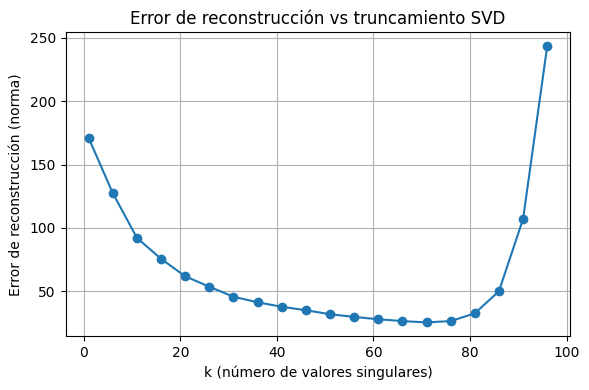

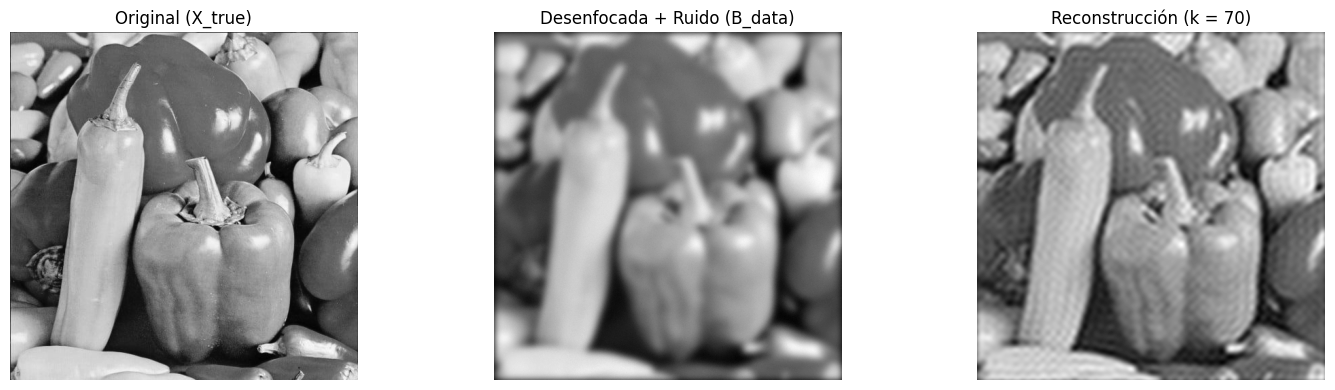

In [14]:
# Asegúrate de haber cargado:
# - X_true (imagen original)
# - B_data (imagen desenfocada + ruido)
# - Ac, Ar (operadores de blur)

# SVD de Ac y Ar
Uc, Sc, Vhc = np.linalg.svd(Ac, full_matrices=False)
Ur, Sr, Vhr = np.linalg.svd(Ar, full_matrices=False)

# Evaluar varios valores de k
ks = list(range(1, 101, 5))  # desde 1 a 100, en pasos de 5
errores = []

for k in ks:
    # Reconstruir inversas truncadas
    A_c_inv_k = Vhc.T[:, :k] @ np.diag(1 / Sc[:k]) @ Uc[:, :k].T
    A_r_inv_k = Vhr.T[:, :k] @ np.diag(1 / Sr[:k]) @ Ur[:, :k].T
    
    # Reconstrucción aproximada
    X_k = A_c_inv_k @ B_data @ A_r_inv_k
    error_k = np.linalg.norm(X_true - X_k)
    errores.append(error_k)

# Graficar error vs k
plt.figure(figsize=(6, 4))
plt.plot(ks, errores, marker='o')
plt.xlabel("k (número de valores singulares)")
plt.ylabel("Error de reconstrucción (norma)")
plt.title("Error de reconstrucción vs truncamiento SVD")
plt.grid(True)
plt.tight_layout()
plt.show()

# Elegir un k representativo para mostrar la reconstrucción
k = 70
A_c_inv_trunc = Vhc.T[:, :k] @ np.diag(1 / Sc[:k]) @ Uc[:, :k].T
A_r_inv_trunc = Vhr.T[:, :k] @ np.diag(1 / Sr[:k]) @ Ur[:, :k].T
X_recon = A_c_inv_trunc @ B_data @ A_r_inv_trunc

# Mostrar comparaciones visuales
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_true, cmap='gray')
plt.axis('off')
plt.title('Original (X_true)')

plt.subplot(1, 3, 2)
plt.imshow(B_data, cmap='gray')
plt.axis('off')
plt.title('Desenfocada + Ruido (B_data)')

plt.subplot(1, 3, 3)
plt.imshow(X_recon, cmap='gray')
plt.axis('off')
plt.title(f'Reconstrucción (k = {k})')

plt.tight_layout()
plt.show()


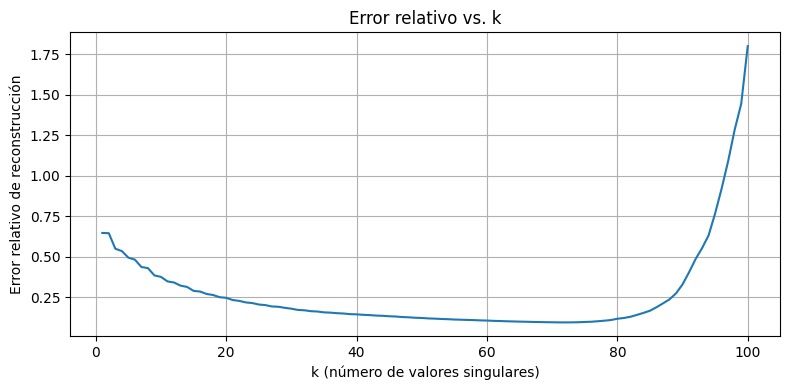

In [15]:
ks = np.arange(1, 101)
errors = []

for k in ks:
    # Truncar
    A_c_inv_k = Vhc.T[:, :k] @ np.diag(1 / Sc[:k]) @ Uc[:, :k].T
    A_r_inv_k = Vhr.T[:, :k] @ np.diag(1 / Sr[:k]) @ Ur[:, :k].T
    
    X_recon_k = A_c_inv_k @ B_data @ A_r_inv_k
    error_rel = np.linalg.norm(X_true - X_recon_k) / np.linalg.norm(X_true)
    errors.append(error_rel)

plt.figure(figsize=(8,4))
plt.plot(ks, errors)
plt.xlabel('k (número de valores singulares)')
plt.ylabel('Error relativo de reconstrucción')
plt.title('Error relativo vs. k')
plt.grid(True)
plt.tight_layout()
plt.show()


A_c_inv_trunc: (512, 512)
A_r_inv_trunc: (512, 512)
Error con truncamiento (k=70): 0.09395105127119371
Error sin truncamiento: 616537729.1303024
Residuo con truncamiento (k=70): 0.6037050241507784
Residuo sin truncamiento: 0.00922184692523136


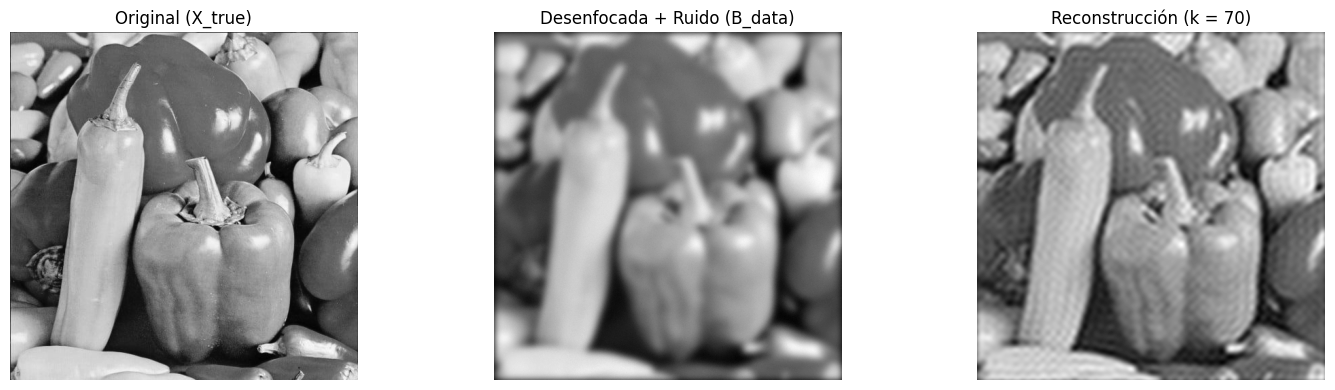

In [16]:
# Función para obtener la pseudo-inversa truncada por SVD

Ac, Ar = blur_operator(512, 512, bl=1)

def pinv_trunc_svd(A, k):
    """
    Retorna la pseudo-inversa truncada de la matriz A usando los k valores singulares más grandes.
    """
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    
    # Truncar
    U_k = U[:, :k]
    s_k = s[:k]
    Vt_k = Vt[:k, :]
    
    # Invertir los valores singulares truncados
    S_inv = np.diag(1 / s_k)
    
    # Pseudo-inversa truncada
    A_inv_trunc = Vt_k.T @ S_inv @ U_k.T
    return A_inv_trunc

k = 70  # Puedes probar otros valores: 5, 10, 100, etc.

# Inversas truncadas
A_c_inv_trunc = pinv_trunc_svd(Ac, k)
A_r_inv_trunc_T = pinv_trunc_svd(Ar.T, k)  # Nota: necesitamos A_r^{-\top}

print("A_c_inv_trunc:", A_c_inv_trunc.shape)
print("A_r_inv_trunc:", A_r_inv_trunc.shape)

# Reconstrucción    
X_recon = A_c_inv_trunc @ B_blur @ A_r_inv_trunc_T

# Inversas completas (no recomendadas si A_c o A_r son mal condicionadas)
A_c_inv = np.linalg.pinv(Ac)
A_r_inv_T = np.linalg.pinv(Ar.T)

X_sin_truncar = A_c_inv @ B_blur @ A_r_inv_T

# Error relativo
error_recon = np.linalg.norm(X_true - X_recon) / np.linalg.norm(X_true)
error_sin_trunc = np.linalg.norm(X_true - X_sin_truncar) / np.linalg.norm(X_true)

print(f"Error con truncamiento (k={k}):", error_recon)
print("Error sin truncamiento:", error_sin_trunc)

# Comparar normas de residuo
residuo_con_trunc = np.linalg.norm(B_blur - Ac @ X_recon @ Ar.T)
residuo_sin_trunc = np.linalg.norm(B_blur - Ac @ X_sin_truncar @ Ar.T)

print(f"Residuo con truncamiento (k={k}):", residuo_con_trunc)
print("Residuo sin truncamiento:", residuo_sin_trunc)

""" # Evaluar varios valores de k
ks = list(range(1, 101, 5))  # desde 1 a 100, en pasos de 5
errores = []

for k in ks:
    # Reconstruir inversas truncadas
    A_c_inv_k = Vhc.T[:, :k] @ np.diag(1 / Sc[:k]) @ Uc[:, :k].T
    A_r_inv_k = Vhr.T[:, :k] @ np.diag(1 / Sr[:k]) @ Ur[:, :k].T
    
    # Reconstrucción aproximada
    X_k = A_c_inv_k @ B_data @ A_r_inv_k
    error_k = np.linalg.norm(X_true - X_k)
    errores.append(error_k)

# Graficar error vs k
plt.figure(figsize=(6, 4))
plt.plot(ks, errores, marker='o')
plt.xlabel("k (número de valores singulares)")
plt.ylabel("Error de reconstrucción (norma)")
plt.title("Error de reconstrucción vs truncamiento SVD")
plt.grid(True)
plt.tight_layout()
plt.show()
 """
# Elegir un k representativo para mostrar la reconstrucción
k = 70
A_c_inv_trunc = Vhc.T[:, :k] @ np.diag(1 / Sc[:k]) @ Uc[:, :k].T
A_r_inv_trunc = Vhr.T[:, :k] @ np.diag(1 / Sr[:k]) @ Ur[:, :k].T
X_recon = A_c_inv_trunc @ B_data @ A_r_inv_trunc

# Mostrar comparaciones visuales
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_true, cmap='gray')
plt.axis('off')
plt.title('Original (X_true)')

plt.subplot(1, 3, 2)
plt.imshow(B_data, cmap='gray')
plt.axis('off')
plt.title('Desenfocada + Ruido (B_data)')

plt.subplot(1, 3, 3)
plt.imshow(X_recon, cmap='gray')
plt.axis('off')
plt.title(f'Reconstrucción (k = {k})')

plt.tight_layout()
plt.show()




## 1. Singular Value Decomposition (SVD)

### ¿Qué es la SVD?
La **descomposición en valores singulares** de una matriz `A ∈ ℝ^{m×n}` es:

\[
A = U \Sigma V^T
\]

Donde:
- `U ∈ ℝ^{m×m}`: matriz ortogonal de vectores propios de `AAᵀ`.
- `Σ ∈ ℝ^{m×n}`: matriz diagonal con los **valores singulares** \( \sigma_1 ≥ \sigma_2 ≥ ... ≥ \sigma_r > 0 \).
- `V ∈ ℝ^{n×n}`: matriz ortogonal de vectores propios de `AᵀA`.

### Propiedades clave:
- Los valores singulares son **raíz cuadrada de los autovalores** de `AᵀA`.
- Permite representar `A` como suma de matrices rank-1:

\[
A = \sum_{i=1}^r \sigma_i u_i v_i^T
\]

- SVD siempre existe para cualquier matriz, incluso no cuadrada.

---

## 2. Truncamiento SVD (Aproximación de Rango Bajo)

- La **aproximación de rango k** de una matriz `A` es:

\[
A_k = \sum_{i=1}^k \sigma_i u_i v_i^T
\]

- Es la mejor aproximación (en norma 2 y Frobenius) entre todas las matrices de rango ≤ k:

\[
\|A - A_k\|_F \text{ es mínima}
\]

- **Se usa para**: compresión, reducción de ruido, reconstrucción aproximada, entre otros.

---

## 3. Principal Component Analysis (PCA)

### ¿Qué es?
PCA es una técnica para reducir la dimensionalidad buscando una base ortogonal que **maximiza la varianza** de los datos proyectados.

### Conexión con SVD:
- Si `X` es la matriz de datos centrada, entonces:

\[
X = U \Sigma V^T
\Rightarrow \text{Componentes principales = columnas de } V
\]

- Los valores singulares \( \sigma_i^2 \) representan la **varianza explicada** por cada componente.

---

## 4. Aplicación a Imágenes y Reconstrucción

### Caso del laboratorio:
Queremos reconstruir una imagen `X_true` observada indirectamente a través de:

\[
B = A_c X A_r^T + \text{ruido}
\]

Donde:
- `A_c`, `A_r`: operadores de desenfoque (blur).
- `B`: imagen desenfocada y ruidosa.
- `X`: imagen verdadera.
- `B_data`: observación con ruido.

---

### Inversión usando SVD:
Usamos la pseudo-inversa truncada:

\[
X_k \approx A_c^{-1} B A_r^{-T} = V_c[:, :k] Σ_c^{-1} U_c[:, :k]^T \cdot B \cdot U_r[:, :k] Σ_r^{-1} V_r[:, :k]^T
\]

### Justificación:
- Truncar reduce el efecto del **ruido**, ya que los valores singulares pequeños amplifican el error en la inversión.
- Hay un compromiso entre:
  - **Pérdida de información** (por descartar componentes importantes),
  - **Reducción de ruido** (por eliminar componentes inestables).

---

## 5. ¿Cómo elegir el mejor k?

### Criterios comunes:
- **Energía acumulada**: Retener un porcentaje (e.g. 99%) de la varianza total.
- **Método del codo**: Detectar el punto donde la disminución de \( \sigma_i \) se vuelve menos significativa.
- **Error relativo de reconstrucción** (si se conoce la imagen real):

\[
\frac{\|X_k - X_{\text{true}}\|_F}{\|X_{\text{true}}\|_F}
\]


### ¿Qué representa cada componente de la SVD?
- `U`: Direcciones principales del espacio de salida (columnas ortogonales).
- `Σ`: Valores singulares, que indican **cuánto contribuye** cada dirección a la transformación.
- `Vᵀ`: Direcciones principales del espacio de entrada.
- Interpretación: `A` transforma vectores `x` primero rotando (por `Vᵀ`), luego escalando (por `Σ`), y finalmente rotando de nuevo (por `U`).

---

### ¿Por qué usar SVD para invertir operadores ruidosos?
- Porque la **pseudo-inversa basada en SVD** permite invertir solo las componentes más estables (las que tienen valores singulares altos).
- Invertir directamente (`np.linalg.inv`) puede amplificar el ruido si los valores singulares son pequeños.
- SVD también funciona para matrices no cuadradas o mal condicionadas, donde la inversa directa no es aplicable.

---

### ¿Por qué truncar la SVD ayuda contra el ruido?
- El ruido suele proyectarse en componentes de **baja energía** (valores singulares pequeños).
- Al truncar la SVD, se descartan esas componentes inestables, lo que actúa como un **filtro de ruido**.
- Se logra un equilibrio entre fidelidad y robustez.

---

### ¿Cuál es la conexión entre SVD y PCA?
- PCA se puede obtener aplicando la SVD a la matriz de datos centrada.
- Las **componentes principales** son las columnas de `V` (o filas de `Vᵀ`) en la SVD.
- Los **valores singulares al cuadrado** son proporcionales a la varianza explicada por cada componente.

---

### ¿Por qué los valores singulares pequeños son peligrosos al invertir?
- Porque en la inversión se toma \( 1 / \sigma_i \), y si \( \sigma_i \) es pequeño, el resultado será muy grande.
- Esto amplifica cualquier error (por ejemplo, ruido) presente en los datos observados.
- Truncar evita esta amplificación.

---

## 📌 Computacionales

### ¿Qué complejidad tiene la SVD?
- Para una matriz `m × n`, la SVD completa tiene complejidad \( O(mn^2) \) si \( m ≥ n \).
- Es más costosa que otras descomposiciones (como QR o LU), pero más estable y versátil.

---

### ¿Por qué usar `np.linalg.svd` en vez de invertir directamente?
- La inversión directa (`np.linalg.inv`) requiere que la matriz sea **cuadrada y no singular**, y es sensible al ruido.
- La SVD permite obtener la **pseudo-inversa** incluso si la matriz es:
  - No cuadrada
  - Mal condicionada
  - Ruidosa
- Además, puedes controlar el grado de inversión truncando.

---

### ¿Cómo usar la SVD para aproximar matrices grandes?
- Se puede tomar solo los primeros `k` valores singulares y vectores asociados para obtener:

\[
A_k = \sum_{i=1}^k \sigma_i u_i v_i^T
\]

- Esto permite **reducir almacenamiento**, **acelerar cálculos**, y **eliminar ruido**.
- Muy útil en compresión de imágenes o reducción de dimensionalidad.

---

## 📌 Aplicadas al laboratorio

### ¿Cómo construiste el operador `A_c`, `A_r`?
- Ambos operadores son matrices `512 × 512` generadas con la función `blur_operator(n, n, bl=1)`.
- Representan un efecto de **desenfoque lineal** aplicado a las filas (`A_r`) y columnas (`A_c`) de la imagen.

---

### ¿Qué criterios usaste para elegir k?
- Se probó con diferentes valores de `k`, evaluando la **calidad de reconstrucción visual** y/o el **error relativo** con respecto a la imagen original `X_true`.
- Se evitó usar valores de `k` demasiado grandes para no amplificar el ruido.

---

### ¿Qué observaste al variar el valor de k?
- Si `k` es muy pequeño: se pierde mucha información → imagen borrosa o distorsionada.
- Si `k` es muy grande: se recupera información detallada, pero también se amplifica el ruido.
- Existe un **punto intermedio óptimo** donde el error de reconstrucción es mínimo.

---

### ¿Qué pasa si k es muy grande o muy chico?
- **k muy chico**:
  - Se filtran componentes importantes.
  - Imagen reconstruida pierde detalles esenciales.
- **k muy grande**:
  - Se incluyen componentes dominadas por ruido.
  - La reconstrucción puede volverse inestable o ruidosa.

---
